In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import os

In [44]:
os.chdir("C:\\Users\\Hariharan\\Documents\\replications\\mrw1992")

In [45]:
data = pd.read_csv("data/mrw.csv")

#### Reformatting the data

In [46]:
#convenience stuff
data = data.drop(data.columns[0], axis = 1)
data = data.set_index('country')

#creating desired variables
data['lngd'] = np.log(data['popgrowth']/100 + 0.05)
data['ls'] = np.log(data['i_y']/100)
data['const'] = 1
data['ls_lngd'] = data['ls'] - data['lngd']

# Standard Solow Model

The model starts with a Cobb-Douglas production function:

\begin{align*}
Y(t) = K(t)^{\alpha}(A(t)L(t))^{1 - \alpha}
\end{align*}

The evolution of capital is determined by the following equation:

\begin{align*}
\dot{k(t)} = sk(t)^{\alpha} - (n - g - \delta)k(t)
\end{align*}

From this we can get the steady state level of $k(t)$ by equating $\dot{k(t)}$ to 0.  
We then get a simple formula to determine the steady state $k(t)^*$

\begin{align*}
k(t)^* = \left(\frac{s}{n + g + \delta}\right)^{1/(1 - \alpha)}
\end{align*}

We can take logs of the production function and substitute in $\dot{k(t)}$ to find the equation we want to estimate, which is the steady state level of output. We also add an initial $A(0)$ which we take as equal to $a + \epsilon$ where $a$ is a constant and $\epsilon$ is a country specific shock

\begin{align*}
log(Y/L) = a + \frac{\alpha}{(1 - \alpha)}log(s) - \frac{\alpha}{(1 - \alpha)}log(n + g + \delta) + \epsilon
\end{align*}

where:
a is the constant in the assumed $log(A)$ equation  
$\epsilon$ is the country shock for $log(a)$  
$\alpha$ is the share of capital  
s is the exogenous savings rate (measured with average share of investment in GDP)  
n is the exogenous population growth rate  
g is the exogenous tfp growth rate  
$\delta$ is the depriciation rate of capital  

This corresponds to equation 7 in the paper

In [47]:
data['lschool'] = np.log(data['school'])
data['lsch_ngd'] = data['lschool'] - data['lngd']
data['ly60'] = np.log(data['rgdpw60'])
data['ly85'] = np.log(data['rgdpw85'])
data['linv'] = np.log(data['i_y'])

#subsetting data
data_reg = data.loc[data['n'] == 1, :] #no oil
data_d = data_reg[data_reg.i == 1] #pop in 1960 less than 1 mil
data_oecd = data_reg[data_reg.o == 1] #oecd

Unrestricted Model

In [48]:
#no restrictions on coefficients here
reg1 = sm.OLS(endog = data_reg['ly85'],
              exog = data_reg[['const', 'ls', 'lngd']],
             missing = 'drop').fit()

reg2 = sm.OLS(endog = data_d['ly85'],
             exog = data_d[['const', 'ls', 'lngd']],
             missing = 'drop').fit()

reg3 = sm.OLS(endog = data_oecd['ly85'],
             exog = data_oecd[['const', 'ls', 'lngd']],
             missing = 'drop').fit()

Restricted Model

In [49]:
#coeff(log(savings)) = -coeff(log(n+g+d))
regr1 = sm.OLS(endog = data_reg['ly85'],
             exog = data_reg[['const', 'ls_lngd']],
             missing = 'drop').fit()

regr2 = sm.OLS(endog = data_d['ly85'],
             exog = data_d[['const', 'ls_lngd']],
             missing = 'drop').fit()

regr3 = sm.OLS(endog = data_oecd['ly85'],
             exog = data_oecd[['const', 'ls_lngd']],
             missing = 'drop').fit()

Making table 1

In [50]:
info_dict = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1]):.2f}"}

results_unres = summary_col(results = [reg1, reg2, reg3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'ls',
                                             'lngd'])


results_res = summary_col(results = [regr1, regr2, regr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'ls',
                                             'ls_lngd'])


results_res.add_title('Restricted Regressions')
results_unres.add_title('Unrestricted Regressions')
print(results_unres)
print('')
print(results_res)

       Unrestricted Regressions
          Non-Oil  Intermediate   OECD 
---------------------------------------
const     5.43***  5.35***      8.02***
          (1.58)   (1.54)       (2.52) 
ls        1.42***  1.32***      0.50   
          (0.14)   (0.17)       (0.43) 
lngd      -1.99*** -2.02***     -0.74  
          (0.56)   (0.53)       (0.85) 
R^2       0.5925   0.5878       0.0118 
N         98.0000  75.0000      22.0000
s.e.e.    0.6891   0.6106       0.3774 
Implied α 0.59     0.57         0.33   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

        Restricted Regressions
          Non-Oil Intermediate   OECD 
--------------------------------------
const     6.87*** 7.09***      8.62***
          (0.12)  (0.15)       (0.53) 
ls_lngd   1.49*** 1.43***      0.55   
          (0.12)  (0.14)       (0.37) 
R^2       0.5932  0.5861       0.0582 
N         98.0000 75.0000      22.0000
s.e.e.    0.6885  0.6119       0.3684 
Implied α 0.60    0.59         0.36   
Standar

### Interpretting

Lets not get starry eyed with the regression tables too quickly.  

MRW take these regression tables with cautious optimism. While we see the direction and significance in the variables we want in the way we expect - i.e. savings positively determines steady state level of output per capita, and $(n + g + \delta)$ negatively affects output per capita. Also putting a restriction on the coefficient $(n + g + \delta)$ doesn't really change our results too much. 
Also, the model seems to explain a lot of the cross country variation in output per capita ($R^2$ is fairly high). But this shouldn't be taken as evidence for the Solow model. 

The big but here is that the implied $\alpha$ level isn't consistent with the empirical level of capital share, according to which the capital share should've been around 1/3.  

This basically amounts to these regressions being very weak evidence for the Solow model. If we think of all the things the Solow model says, this regression only says 1 thing: savings, population growth and depriciation are highly correlated to GDP, which is consistent with an entire class of growth models. 

Because of this, MRW augment the solow model

# Augmenting the Solow Model

MRW Augment the Solow model with human capital. 

With that, the Cobb-Douglas production function becomes:
\begin{align*}
Y(t) = K(t)^{\alpha}H(t)^{\beta}(A(t)L(t))^{1 - \alpha - \beta}
\end{align*}

Evolution of the economy is determined by:

\begin{align*}
\dot{k(t)} = s_{k}y(t) - (n + g +\delta)k(t)\\
\dot{h(t)} = s_{h}y(t) - (n + g +\delta)h(t)
\end{align*}

We can use these to derive the steady state values for k and h by setting $\dot{k(t)}$ and $\dot{h(t)}$ to 0.  
Using those we can arrive at the equation that we want to estimate.

\begin{align*}
log(Y(t)/L(t)) = log(A(0)) + gt + \frac{\alpha}{1 - \alpha - \beta}log(s_k) - \frac{\alpha + \beta}{1 - \alpha - \beta}log(n + g + \delta) + \frac{\beta}{1 - \alpha -\beta}log(s_h)
\end{align*}

This is very similar to the standard solow model equation we estimated before except for the last term. We can think of the last term being in the error term in our previous specification. This would'nt be a problem by itself but since $s_h$ is determined by $s_k$ and $n$, this would've biased our coefficients in the previous specification

Unrestricted Model

In [51]:
#no restrictions on coefficients here
regh1 = sm.OLS(endog = data_reg['ly85'],
             exog = data_reg[['const', 'ls', 'lngd', 'lschool']],
             missing = 'drop').fit()

regh2 = sm.OLS(endog = data_d['ly85'],
             exog = data_d[['const', 'ls', 'lngd', 'lschool']],
             missing = 'drop').fit()

regh3 = sm.OLS(endog = data_oecd['ly85'],
             exog = data_oecd[['const', 'ls', 'lngd', 'lschool']],
             missing = 'drop').fit()

Restricted Model

In [52]:
#coeff(log(savings)) = -coeff(log(n+g+d))
reghr1 = sm.OLS(endog = data_reg['ly85'],
             exog = data_reg[['const', 'ls_lngd', 'lsch_ngd']],
             missing = 'drop').fit()

reghr2 = sm.OLS(endog = data_d['ly85'],
             exog = data_d[['const', 'ls_lngd', 'lsch_ngd']],
             missing = 'drop').fit()

reghr3 = sm.OLS(endog = data_oecd['ly85'],
             exog = data_oecd[['const', 'ls_lngd', 'lsch_ngd']],
             missing = 'drop').fit()

In [53]:
info_dictu = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[3]):.2f}",
            'Implied β': lambda x: f"{x.params[3]/(1 + x.params[1] + x.params[3]):.2f}"}

info_dictr = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[2]):.2f}",
            'Implied β': lambda x: f"{x.params[2]/(1 + x.params[1] + x.params[2]):.2f}"}

results_unres = summary_col(results = [regh1, regh2, regh3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictu,
                           regressor_order = ['const',
                                             'ls',
                                             'lngd',
                                             'lschool'])


results_res = summary_col(results = [reghr1, reghr2, reghr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictr,
                           regressor_order = ['const',
                                             'ls',
                                             'ls_lngd',
                                             'lsch_ngd'])


results_res.add_title('Restricted Regressions')
results_unres.add_title('Unrestricted Regressions')
print(results_unres)
print('')
print(results_res)

       Unrestricted Regressions
          Non-Oil  Intermediate   OECD 
---------------------------------------
const     3.83***  4.43***      5.10*  
          (1.18)   (1.16)       (2.47) 
ls        0.70***  0.70***      0.28   
          (0.13)   (0.15)       (0.39) 
lngd      -1.75*** -1.50***     -1.08  
          (0.42)   (0.40)       (0.76) 
lschool   0.65***  0.73***      0.77** 
          (0.07)   (0.10)       (0.29) 
R^2       0.7788   0.7714       0.2444 
N         98.0000  75.0000      22.0000
s.e.e.    0.5077   0.4547       0.3300 
Implied α 0.30     0.29         0.14   
Implied β 0.28     0.30         0.38   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

        Restricted Regressions
          Non-Oil Intermediate   OECD 
--------------------------------------
const     4.83*** 4.59***      5.18***
          (0.24)  (0.34)       (1.36) 
ls_lngd   0.74*** 0.71***      0.28   
          (0.12)  (0.14)       (0.33) 
lsch_ngd  0.66*** 0.73***      0.77** 
    

#### Interpretation and Evaluation

The $\alpha$ and $\beta$ implied from the regressions are much closer to what we would expect. So adding human capital seems to have improved the Solow model's performance. $R^2$ also seems to be much higher.

There's a big elephant in the room which we should address at this point. Endogeneity.

MRW really take no worry of endogeneity issues in these regressions. Endogeneity comes in 3 flavours:
1. Ommitted variable bias: Is the error term in the equations we estimated orthogonal to the exogenous regressors and the outcome? Probably not. For example, level of institutions in a country would be correlated to the savings rate and the GDP (possible correlated positively with both). This would mean that we have estimates with an upward bias
2. Reverse Causality: Is it likely that gdp affects savings? Yes. We can imagine that higher gdp would increase or decrease the savings rate. Either way, this again implies a bias in our estimates.
3. Measurement Error: Is it likely that one or more of our RHS variables are mismeasuring what we actually want to measure. Take for instance human-capital. We assumed $s_h$ to be our proxy for it. But if there is measurement error there, that error will be present in our residual in the regression, which will then be correlated with our RHS variable thus biasing the estimates.

It almost seems circular to follow these regressions to conclude that the Solow model is right. If we take these regressions as correctly specified, we are basically assuming all our righthand-side variables to be exogenous, which is already half way there to the assumptions of Solow, where we take savings and growth rates as exogenous.

It will also be interesting to see how sensitive these results are to what we use for human capital. For example, it isn't clear why we should restrict human-capital to be restricted to the share of the working-age population in secondary school.

That is not to say that these regressions are useless. Even if the argument is a bit circular, the fact that the magnitudes of $\alpha$ and $\beta$ turn out as predicted is still impressive. But it seems more predictive than causal

## Solow Rate of Convergence

Now we move on to estimating the rate of convergence in a Solow model.

If we start out with our base cobb douglas equation for output per worker, try to solve for the relative growth rate of y, on the way applying some taylor approxiamtions and stuff we know from differential equations, we get a linear equation that we can estimate to give us an idea of the rate of convergence:

\begin{align}
\ln(y(t)) - \ln(y(0)) = (1 - e^{-\lambda t})\left(\frac{\alpha}{1 - \alpha - \beta}\right)\ln(s_k) + (1 - e^{-\lambda t})\left(\frac{\beta}{1 - \alpha - \beta}\right)\ln(s_h) - (1 - e^{-\lambda t})\left(\frac{\alpha + \beta}{1 - \alpha + \beta}\right)\ln(n + g+ \delta) - (1 - e^{-\lambda t})\ln(y(0))
\end{align}

First we will go through a much more basic regression: 
\begin{align}
\ln(y(t)) - \ln(y(0)) = \beta_0 + \beta_1 \ln(y(0)) + \epsilon
\end{align}

In [54]:
regcon1 = sm.OLS(endog = (data_reg['ly85'] - data_reg['ly60']),
               exog = data_reg[['const', 'ly60']],
               missing = 'drop').fit()

regcon2 = sm.OLS(endog = (data_d['ly85'] - data_d['ly60']),
               exog = data_d[['const', 'ly60']],
               missing = 'drop').fit()

regcon3 = sm.OLS(endog = (data_oecd['ly85'] - data_oecd['ly60']),
               exog = data_oecd[['const', 'ly60']],
               missing = 'drop').fit()

In [55]:
info_dictroc = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}

table_roc = summary_col(results = [regcon1, regcon2, regcon3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'ly60'])

table_roc.add_title('Tests for Unconditional Convergence')
print(table_roc)

    Tests for Unconditional Convergence
           Non-Oil  Intermediate     OECD   
--------------------------------------------
const     -0.26658  0.58752      3.68629*** 
          (0.37960) (0.43293)    (0.68490)  
ly60      0.09431*  -0.00424     -0.34110***
          (0.04962) (0.05484)    (0.07852)  
R^2       0.0262    -0.0136      0.4597     
N         98.0000   75.0000      22.0000    
s.e.e.    0.4405    0.4077       0.1830     
Implied λ -0.00360  0.00017      0.01669    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [56]:
regcon4 = sm.OLS(endog = (data_reg['ly85'] - data_reg['ly60']),
               exog = data_reg[['const', 'ly60', 'ls', 'lngd']],
               missing = 'drop').fit()

regcon5 = sm.OLS(endog = (data_d['ly85'] - data_d['ly60']),
               exog = data_d[['const', 'ly60', 'ls', 'lngd']],
               missing = 'drop').fit()

regcon6 = sm.OLS(endog = (data_oecd['ly85'] - data_oecd['ly60']),
               exog = data_oecd[['const', 'ly60', 'ls', 'lngd']],
               missing = 'drop').fit()



regcon7 = sm.OLS(endog = (data_reg['ly85'] - data_reg['ly60']),
               exog = data_reg[['const', 'ly60', 'ls', 'lngd', 'lschool']],
               missing = 'drop').fit()

regcon8 = sm.OLS(endog = (data_d['ly85'] - data_d['ly60']),
               exog = data_d[['const', 'ly60', 'ls', 'lngd', 'lschool']],
               missing = 'drop').fit()

regcon9 = sm.OLS(endog = (data_oecd['ly85'] - data_oecd['ly60']),
               exog = data_oecd[['const', 'ly60', 'ls', 'lngd', 'lschool']],
               missing = 'drop').fit()

In [57]:
info_dictroc2 = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}

table_roc2 = summary_col(results = [regcon4, regcon5, regcon6],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'ly60',
                                             'ls',
                                             'lngd'])


table_roc3 = summary_col(results = [regcon7, regcon8, regcon9],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'ly60',
                                             'ls',
                                             'lngd',
                                             'lschool'])

table_roc2.add_title('Tests for Conditional Convergence')
table_roc3.add_title('Tests for Conditional Convergence')
print(table_roc2)
print(" ")
print(table_roc3)

      Tests for Conditional Convergence
            Non-Oil   Intermediate     OECD   
----------------------------------------------
const     1.91938**   2.24968**    2.14036*   
          (0.83367)   (0.85472)    (1.18068)  
ly60      -0.14090*** -0.22783***  -0.34991***
          (0.05202)   (0.05725)    (0.06574)  
ls        0.64724***  0.64587***   0.39010**  
          (0.08670)   (0.10392)    (0.17612)  
lngd      -0.30235    -0.45746     -0.76624** 
          (0.30438)   (0.30743)    (0.34523)  
R^2       0.3828      0.3526       0.6228     
N         98.0000     75.0000      22.0000    
s.e.e.    0.3507      0.3258       0.1529     
Implied λ 0.00607     0.01034      0.01723    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
 
      Tests for Conditional Convergence
            Non-Oil   Intermediate     OECD   
----------------------------------------------
const     1.95719**   2.46351***   1.70676    
          (0.77744)   (0.80116)    (1.16846)  
ly60      -0.

In [58]:
regconr1 = sm.OLS(endog = (data_reg['ly85'] - data_reg['ly60']),
               exog = data_reg[['const', 'ly60', 'ls_lngd', 'lsch_ngd']],
               missing = 'drop').fit()

regconr2 = sm.OLS(endog = (data_d['ly85'] - data_d['ly60']),
               exog = data_d[['const', 'ly60', 'ls_lngd', 'lsch_ngd']],
               missing = 'drop').fit()

regconr3 = sm.OLS(endog = (data_oecd['ly85'] - data_oecd['ly60']),
               exog = data_oecd[['const', 'ly60', 'ls_lngd', 'lsch_ngd']],
               missing = 'drop').fit()

Replicating Figure 1

In [59]:
info_dictrocr = {'R^2': lambda x: x.rsquared_adj,
            'N': lambda x: x.nobs,
            's.e.e.': lambda x: np.sqrt(x.scale),
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}
table_rocr = summary_col(results = [regconr1, regconr2, regconr3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'ly60',
                                             'ls_lngd', 
                                              'lsch_ngd'])

table_rocr.add_title('Rate of Convergence - Restricted')
print(table_rocr)

       Rate of Convergence - Restricted
            Non-Oil   Intermediate     OECD   
----------------------------------------------
const     1.37384***  1.86679***   2.44270*** 
          (0.33571)   (0.36760)    (0.69118)  
ly60      -0.29790*** -0.37236***  -0.40221***
          (0.06041)   (0.06687)    (0.06918)  
ls_lngd   0.50067***  0.50635***   0.39532**  
          (0.08219)   (0.09508)    (0.15174)  
lsch_ngd  0.23519***  0.26569***   0.24125    
          (0.05916)   (0.08000)    (0.14244)  
R^2       0.4651      0.4371       0.6586     
N         98.0000     75.0000      22.0000    
s.e.e.    0.3265      0.3038       0.1454     
Implied λ 0.01415     0.01863      0.02058    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Replicating plots

First we carry out some regressions for panel B and C to get out the residuals we need

In [80]:
reg_plt2 = sm.OLS(data_d['ly60'],
                 data_d[['lngd', 'linv']],
                 missing = 'drop').fit()
residly601 = reg_plt2.resid

reg_plt3 = sm.OLS(data_d['ly85'] - data_d['ly60'],
                 data_d[['lngd', 'linv']],
                 missing = 'drop').fit()
residgr1 = reg_plt3.resid




reg_plt4 = sm.OLS(data_d['ly60'],
                 data_d[['lngd', 'linv', 'lschool']],
                 missing = 'drop').fit()
residly602 = reg_plt4.resid

reg_plt5 = sm.OLS(data_d['ly85'] - data_d['ly60'],
                 data_d[['lngd', 'linv', 'lschool']],
                 missing = 'drop').fit()
residgr2 = reg_plt5.resid



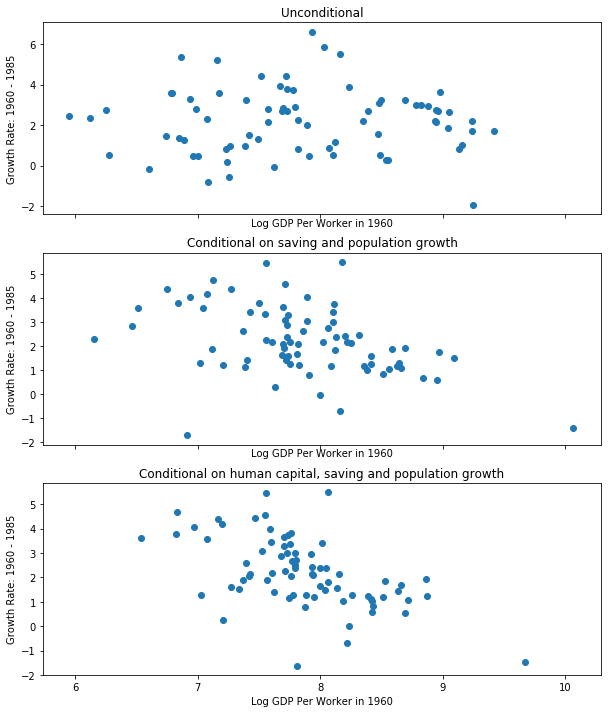

In [88]:
fig, ax = plt.subplots(3, 1, sharex = 'col', figsize = (10, 12))
ax[0].scatter(data_d['ly60'], (data_d['ly85'] - data_d['ly60'])*100/25)
ax[0].set_xlabel('Log GDP Per Worker in 1960')
ax[0].set_ylabel('Growth Rate: 1960 - 1985')
ax[0].set_title('Unconditional')


ax[1].scatter(residly601 + np.mean(data_d['ly60']), 
           (residgr1 + np.mean(data_d['ly85'] - data_d['ly60']))*100/25)
ax[1].set_xlabel('Log GDP Per Worker in 1960')
ax[1].set_ylabel('Growth Rate: 1960 - 1985')
ax[1].set_title('Conditional on saving and population growth')


ax[2].scatter(residly602 + np.mean(data_d['ly60']), 
           (residgr2 + np.mean(data_d['ly85'] - data_d['ly60']))*100/25)
ax[2].set_xlabel('Log GDP Per Worker in 1960')
ax[2].set_ylabel('Growth Rate: 1960 - 1985')
ax[2].set_title('Conditional on human capital, saving and population growth')
plt.show()

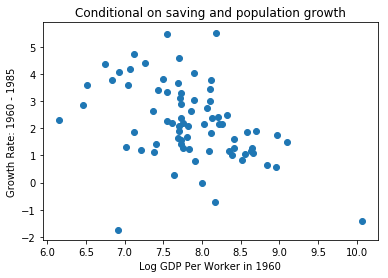

In [72]:
fix, ax = plt.subplots()
ax.scatter(residly60 + np.mean(data_d['ly60']), 
           (residgr + np.mean(data_d['ly85'] - data_d['ly60']))*100/25)
ax.set_xlabel('Log GDP Per Worker in 1960')
ax.set_ylabel('Growth Rate: 1960 - 1985')
ax.set_title('Conditional on saving and population growth')
plt.show()

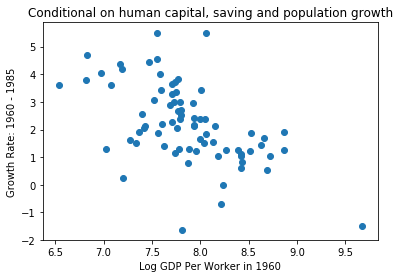

In [74]:

fix, ax = plt.subplots()
ax.scatter(residly60 + np.mean(data_d['ly60']), 
           (residgr + np.mean(data_d['ly85'] - data_d['ly60']))*100/25)
ax.set_xlabel('Log GDP Per Worker in 1960')
ax.set_ylabel('Growth Rate: 1960 - 1985')
ax.set_title('Conditional on human capital, saving and population growth')
plt.show()